In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
# Load the dataset
data = pd.read_csv("NFLX Historical Data.csv")
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,07/19/2024,633.34,660.64,678.97,629.12,9.79M,-1.51%
1,07/18/2024,643.04,656.60,657.04,639.16,7.58M,-0.68%
2,07/17/2024,647.46,650.00,650.45,639.47,4.02M,-1.35%
3,07/16/2024,656.32,661.80,663.67,649.13,2.69M,-0.02%
4,07/15/2024,656.45,647.50,667.54,646.63,3.21M,1.37%


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1144 non-null   object 
 1   Price     1144 non-null   float64
 2   Open      1144 non-null   float64
 3   High      1144 non-null   float64
 4   Low       1144 non-null   float64
 5   Vol.      1144 non-null   object 
 6   Change %  1144 non-null   object 
dtypes: float64(4), object(3)
memory usage: 62.7+ KB
None


In [4]:
# Check for missing values and handle them
print(data.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [5]:
# Interpolate or remove missing values
# data = data.interpolate()  # Interpolate missing values
# data = data.dropna()  # Drop any remaining missing values

In [6]:
# Convert string values to float
data['Vol.'] = data['Vol.'].str.replace('M', '').astype(float) * 1e6  # Convert volume to float and handle 'M' for millions
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)  # Convert change percentage to float

In [7]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
# Check for ARCH/GARCH effects
# For this, we can use the squared returns (log returns)
data['log_return'] = np.log(data['Price']).diff()
data = data.dropna()  # Drop NaN values created by differencing
data['squared_log_return'] = data['log_return'] ** 2

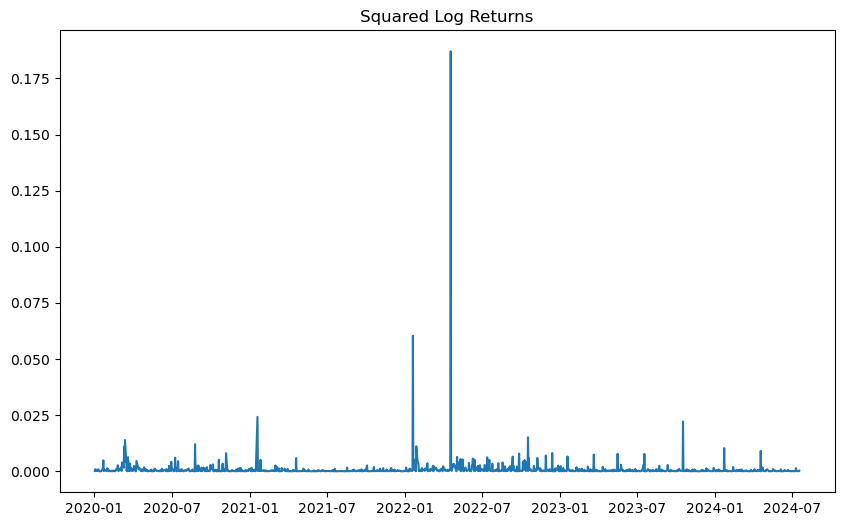

In [9]:
# Plot squared log returns to visually check for ARCH effects
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['squared_log_return'])
plt.title('Squared Log Returns')
plt.show()

In [10]:
# Fit an ARCH/GARCH model
# We'll use a simple GARCH(1, 1) model for this example
model = arch_model(data['log_return'], vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2466.74
Distribution:                  Normal   AIC:                          -4925.49
Method:            Maximum Likelihood   BIC:                          -4905.32
                                        No. Observations:                 1143
Date:                Wed, Jul 24 2024   Df Residuals:                     1142
Time:                        19:38:45   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.5103e-03  8.536e-04     -1.769  7.683e

C:\Users\gauri\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [11]:
# Forecasting the three-month volatility
forecast_horizon = 3 * 30  # Approximate days for three months
forecasts = model_fit.forecast(horizon=forecast_horizon)

In [12]:
# Extract the forecasted variances and convert to volatility (standard deviation)
forecasted_volatility = np.sqrt(forecasts.variance.values[-1])

In [13]:
# Create a DataFrame to display the forecasted values
forecast_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Volatility': forecasted_volatility})

In [14]:
# Display the forecasted values
print(forecast_df)

         Date  Forecasted_Volatility
0  2020-01-03               0.023595
1  2020-01-04               0.023752
2  2020-01-05               0.023904
3  2020-01-06               0.024053
4  2020-01-07               0.024197
..        ...                    ...
85 2020-03-28               0.029342
86 2020-03-29               0.029364
87 2020-03-30               0.029386
88 2020-03-31               0.029408
89 2020-04-01               0.029429

[90 rows x 2 columns]


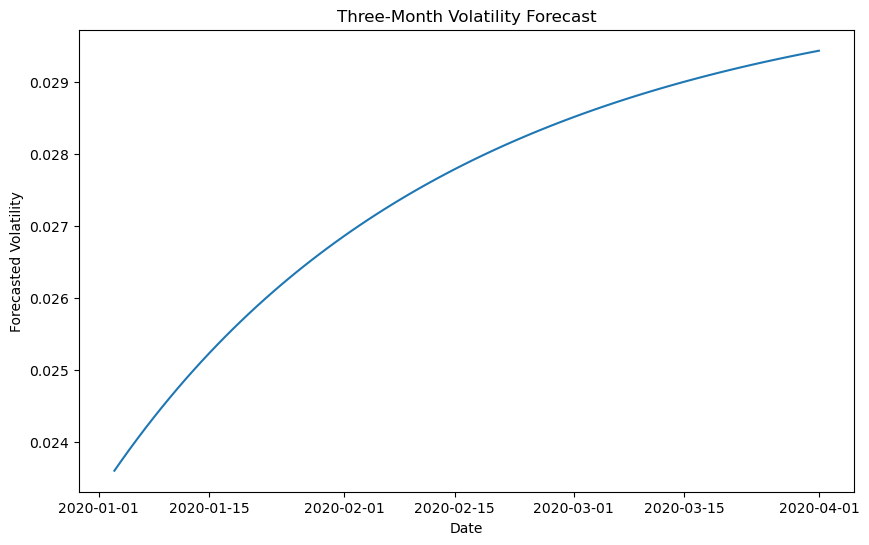

In [15]:
# Plot the forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Volatility'])
plt.title('Three-Month Volatility Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Volatility')
plt.show()

### Part B : VAR/VECM

In [1]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

In [2]:
# Load the dataset
df = pd.read_excel('pinksheet.xlsx', sheet_name="Monthly Prices", skiprows=6)

In [3]:
# Display the first few rows of the dataset
print(df.head())

  Unnamed: 0  CRUDE_PETRO  CRUDE_BRENT  CRUDE_DUBAI CRUDE_WTI COAL_AUS  \
0    1960M01         1.63         1.63         1.63         …        …   
1    1960M02         1.63         1.63         1.63         …        …   
2    1960M03         1.63         1.63         1.63         …        …   
3    1960M04         1.63         1.63         1.63         …        …   
4    1960M05         1.63         1.63         1.63         …        …   

  COAL_SAFRICA  NGAS_US  NGAS_EUR NGAS_JP  ...    ALUMINUM  IRON_ORE  COPPER  \
0            …     0.14  0.404774       …  ...  511.471832     11.42  715.40   
1            …     0.14  0.404774       …  ...  511.471832     11.42  728.19   
2            …     0.14  0.404774       …  ...  511.471832     11.42  684.94   
3            …     0.14  0.404774       …  ...  511.471832     11.42  723.11   
4            …     0.14  0.404774       …  ...  511.471832     11.42  684.75   

    LEAD     Tin  NICKEL   Zinc   GOLD  PLATINUM  SILVER  
0  206.1  2180.

In [5]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [6]:
# Check for missing values
print(df.isnull().sum())

Date           0
CRUDE_PETRO    0
CRUDE_BRENT    0
CRUDE_DUBAI    0
CRUDE_WTI      0
              ..
NICKEL         0
Zinc           0
GOLD           0
PLATINUM       0
SILVER         0
Length: 72, dtype: int64


In [7]:
# Fill or drop missing values as needed
# Here, we'll use forward fill method
df.fillna(method='ffill', inplace=True)

In [16]:
# Select relevant columns (example columns based on your task description)
# Update the column names as per your dataset
columns = ['CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI','SUGAR_EU', 'SUGAR_US','GOLD', 'PLATINUM', 'SILVER']


In [17]:
data = df[columns]

In [11]:
# Strip any leading/trailing spaces from column names
# df.columns = df.columns.str.strip()

In [18]:
# Display the cleaned column names
# print("DataFrame Columns:")
# print(df.columns)

In [19]:
# Update the list of columns to match the actual column names
# columns = ['Crude oil, average', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI', 
#            'Coal, Australian', 'Coal, South African **', 'Natural gas, US', 
#            'Natural gas, Europe', 'Liquefied natural gas, Japan', 'Natural gas index']

In [20]:
# Display the list of columns
# print("Expected Columns:")
# print(columns)

In [21]:
# Check if all columns are present in the DataFrame
# missing_columns = [col for col in columns if col not in df.columns]
# if missing_columns:
#     print(f"Missing columns: {missing_columns}")

#     # Investigate why the columns are missing
#     for col in columns:
#         if col not in df.columns:
#             print(f"Column '{col}' is missing from DataFrame columns.")
# else:
#     print("All columns are present in the DataFrame.")

#     # Select relevant columns
#     data = df[columns]

#     # Ensure all data is numeric
#     data = data.apply(pd.to_numeric)

#     # Display the first few rows of the selected data
#     print(data.head())

In [22]:
# Ensure all data is numeric
data = data.apply(pd.to_numeric)

In [23]:
# VAR Model
model_var = VAR(data)
results_var = model_var.fit(maxlags=15, ic='aic')

In [24]:
# Print summary of VAR model results
print(results_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     12:55:08
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.43241
Nobs:                     763.000    HQIC:                 -0.228828
Log likelihood:          -7226.30    FPE:                   0.151624
AIC:                     -1.89489    Det(Omega_mle):       0.0627259
--------------------------------------------------------------------
Results for equation CRUDE_PETRO
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.325706         0.357186           -0.912           0.362
L1.CRUDE_PETRO          1.548131         0.319333            4.848           0.000
L1.CRUDE_BRENT         -0.350762         0.245

In [28]:
# Forecast with VAR model
n_forecast = 10  # Number of steps to forecast
forecast_var = results_var.forecast(data.values[-results_var.k_ar:], steps=n_forecast)
forecast_var_df = pd.DataFrame(forecast_var, index=pd.date_range(start=data.index[-1], periods=n_forecast+1, freq='M')[1:], columns=data.columns)
print("VAR Model Forecast:")
print(forecast_var_df)

VAR Model Forecast:
                               CRUDE_PETRO  CRUDE_BRENT  CRUDE_DUBAI  \
1970-02-28 00:00:00.000000773    83.848177    86.538113    84.808626   
1970-03-31 00:00:00.000000773    85.954586    88.411427    87.541744   
1970-04-30 00:00:00.000000773    90.541332    92.775001    92.157464   
1970-05-31 00:00:00.000000773    90.766271    92.547416    93.146474   
1970-06-30 00:00:00.000000773    89.035268    90.706686    90.990440   
1970-07-31 00:00:00.000000773    89.781244    92.137634    90.863046   
1970-08-31 00:00:00.000000773    88.748570    91.345674    90.117612   
1970-09-30 00:00:00.000000773    90.759374    93.146222    92.388558   
1970-10-31 00:00:00.000000773    89.887492    91.870642    91.767537   
1970-11-30 00:00:00.000000773    88.756435    90.848455    90.750287   

                               SUGAR_EU  SUGAR_US         GOLD     PLATINUM  \
1970-02-28 00:00:00.000000773  0.324035  0.866785  2321.045673  1024.758885   
1970-03-31 00:00:00.000000773

In [25]:
# VECM Model
# Perform Johansen cointegration test to determine the number of cointegrating relationships
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)
print(johansen_test.lr1)  # Trace statistic
print(johansen_test.cvt)  # Critical values

[375.29607992 262.85033985 164.5078733   96.28450655  52.41371336
  19.97255682   6.29945245   1.12375856]
[[153.6341 159.529  171.0905]
 [120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [26]:
# Assuming one cointegrating relationship for VECM
model_vecm = VECM(data, k_ar_diff=1, coint_rank=1)
results_vecm = model_vecm.fit()

In [27]:
# Print summary of VECM model results
print(results_vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation CRUDE_PETRO
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
L1.CRUDE_PETRO     0.3987      0.302      1.321      0.186      -0.193       0.990
L1.CRUDE_BRENT    -0.1107      0.230     -0.482      0.630      -0.561       0.339
L1.CRUDE_DUBAI    -0.0034      0.195     -0.017      0.986      -0.385       0.378
L1.SUGAR_EU        7.8175      5.779      1.353      0.176      -3.510      19.144
L1.SUGAR_US       -1.3273      3.799     -0.349      0.727      -8.773       6.118
L1.GOLD           -0.0078      0.006     -1.330      0.184      -0.019       0.004
L1.PLATINUM        0.0208      0.004      5.811      0.000       0.014       0.028
L1.SILVER         -0.3321      0.147     -2.259      0.024      -0.620      -0.044
Det. terms outside the coint. relation & lagged endog. parameters for equation 

In [29]:
# Forecast with VECM model
forecast_vecm = results_vecm.predict(steps=n_forecast)
forecast_vecm_df = pd.DataFrame(forecast_vecm, index=pd.date_range(start=data.index[-1], periods=n_forecast+1, freq='M')[1:], columns=data.columns)
print("VECM Model Forecast:")
print(forecast_vecm_df)

VECM Model Forecast:
                               CRUDE_PETRO  CRUDE_BRENT  CRUDE_DUBAI  \
1970-02-28 00:00:00.000000773    80.738108    82.362004    81.727244   
1970-03-31 00:00:00.000000773    80.774397    82.682447    81.746082   
1970-04-30 00:00:00.000000773    80.900057    83.016420    81.875180   
1970-05-31 00:00:00.000000773    81.005210    83.272939    81.984696   
1970-06-30 00:00:00.000000773    81.077067    83.454833    82.060060   
1970-07-31 00:00:00.000000773    81.123957    83.581855    82.109538   
1970-08-31 00:00:00.000000773    81.155131    83.671517    82.142566   
1970-09-30 00:00:00.000000773    81.176462    83.735563    82.165236   
1970-10-31 00:00:00.000000773    81.191436    83.781741    82.181181   
1970-11-30 00:00:00.000000773    81.202128    83.815226    82.192578   

                               SUGAR_EU  SUGAR_US         GOLD    PLATINUM  \
1970-02-28 00:00:00.000000773  0.344483  0.838504  2318.723508  984.719716   
1970-03-31 00:00:00.000000773 